<hr style="border-width:4px; border-color:coral"></hr>

# Homework #1

<hr style="border-width:4px; border-color:coral"></hr>

This home will give you practice using the Python Multiprocessing module.  

* Learn about using pipes to communicate between Python processes

* Learn about timing and efficiency

**Note:** 471 students may do the extra 571 problems for extra credit. 


In [1]:
import multiprocessing as mp
from time import sleep
mp.set_start_method('fork')
from matplotlib.pyplot import *
from numpy import *
import random


## Problem 1  : Pipe chain

<hr style="border-width:4px; border-color:coral"></hr>

In this problem, you will chain together multiple pipes, end-to-end, and send a message down the chain.  The pipes will be connected by processes, or "links".  

### To Do

* Create $N$ links (processes) and $N+1$ pipes.


* Connect the $N$ links using pipes, laid out end-to-end, so that each link is connected to two pipes. 


* From the main process, send the value $n=0$ through the first pipe.  The first link will receive this value, increment the value by 1, and then send the new value through the second pipe.  In this way, send $n$ down the chain. 


* The main process should then receive the final value of $n$ from the last pipe in the chain. 


* Report the value of $n$ from the final pipe.  

Run your code for $N=32$ and report the value of $n$ after you have run your code. 

### Tips

* Use a loop to create the pipes and links, and to connect the pipes. 


In [2]:
# Problem 1 : Pipe chain

def link(pipe_in, pipe_out):
    n = pipe_in.recv()
    n += 1
    pipe_out.send(n)
    
N=32
Pipes=[mp.Pipe() for i in range(N+1)]

Pipes[0][0].send(0)

Jobs=[]
for i in range(N):  
    proc=mp.Process(target=link,args=(Pipes[i][1], Pipes[i+1][0]))
    proc.start()
    Jobs.append(proc)
for job in Jobs:
    job.join()

    
final_value = Pipes[N][1].recv()
print(final_value)

32


## Problem 2  : Ping-Pong

<hr style="border-width:4px; border-color:coral"></hr>

In this problem, you will simulate a game of ping-pong between two processes.  Each process, or "player" will receive the ping-pong ball, and then send it back to other player.  

### To Do

* Create two processes (or "players") and a single pipe. 

* Use the pipe to connect the two players. 

* One player is designated to start the game.  

* Each player, will, in turn, receive the ball, and then return the ball to the other player. 

* The ping-pong game will stop when a maximum number of balls have been hit. 

* Allow an observer to "watch" the game. 

* End the game with a message, e.g. "Thanks for playing!". 

Run your code for 8 back-and-forth hits. 

### Tips

* Use a counter to  keep track of each return.  Count the first "serve" from the player designated to start the game as a hit.   Pass the counter variable between the players. 

* Allow an observer to watch the game by putting print statements in the player processes.  

* Configure the `name` of the player processes with useful names, .e.g. "Player 1", "Player 2".  

* Use variables names that are suggestive of what the variable does.  For example, name your processes "player1" and "player2".  

In [3]:
# Problem 2 : Ping-pong


def play(connection, value):
   
    if value==0:
        print('Player 1 serve')
        sleep(1.5)
    else:
        print('Player 1 hit')
        sleep(1.5)
        
    value +=1
    
    connection.send(value)

def pingpong(connection, serve):
    
    if serve:
        play(connection, 0)

    while True:
        value = connection.recv()
        value+=1
        print(f'Player 2 hit \n')
       

        
        if value ==8:

            break
        play(connection, value)

    print("Thanks for playing! \n")
   
conR, conS = mp.Pipe()
   
player1 = mp.Process(target=pingpong, args=(conR,True))
player2 = mp.Process(target=pingpong, args=(conS,False))
   
player1.start()
player2.start()
    
player1.join()

Player 1 serve
Player 2 hit 

Player 1 hit
Player 2 hit 

Player 1 hit
Player 2 hit 

Player 1 hit
Player 2 hit 

Thanks for playing! 



<hr style="border-width:4px; border-color:coral"></hr>

## Problem 3  :  Computing a mean

<hr style="border-width:4px; border-color:coral"></hr>

In this problem, you will write a function `mp_mean` which computes the average of an array of numbers.  To compute the mean, you will pass chunks of the data to individual processes.  These processes will add up the numbers in their chunk, and pass the sum back to a main process.  The main process will collect the sums and compute the mean. 

A goal of this problem is to determine whether we can improve upon the sum available in Python by computing many smaller sums on separate processes. 

### To do

* Create a Python list of $N$ random numbers in the interval $[0,1]$ (done below). 

* Write a function `mp_mean` that computes the mean of the data using $p$ multiprocesses.  
* Use your function to compute the mean of the numbers in the data array.  Your result should be identical to the result produced without using multiprocessing (see `serial_mean`, below).

* Time the function for $p = 1, 2, 4, 8$ processes. 

* Comment on the timing results you observe.  

Run your job for $N=2^{12} = 4096$.   Verify your results and report timing results.

### Tips

* Create a pipe for each of the $p$ processes.  

* Use a pipe to send the data chunk  `data[m*i:m*(i+1)]`, $m = N/p$, to process `i`.  

* In the target process, receive the data from the pipe, compute the sum, and pass the sum back to the main process. 

* In the main process, accumulate the sums from each process and compute the mean of the data. 


In [4]:
def serial_mean(data):
    N = len(data)
    return sum(data)/N

def mp_mean(data,p):
    N = len(data)
    m = N//p     
    assert p*m == N, "Length of data array should be divisible by p"

    # TODO : Create target process to sum data
    def adder(pipein,data):
        pipein[0].send(sum(data))
        
    
    # TODO : Create p pipes
    Pipes=[mp.Pipe() for i in range(p)]
    
    
    # TODO : Launch p processes, each with a pipe to the main process.  Use target=adder.
    Jobs=[];
    S=0 # initialize the sum
    for i in range(p):
        # TODO : Send p chunks of data through the pipes to each process
        proc=mp.Process(target=adder,args=(Pipes[i],data[m*i:m*(i+1)]))
        proc.start()
        Jobs.append(proc)
        
    #for job in Jobs:
        
    
    for job in Jobs:
        job.join()
    
    # TODO : Receive and accumulate the sums computed from each process
    
    for pipe in Pipes:
        S+=pipe[1].recv()     
    
    # TODO : Compute the mean
    return S/N
    

### Create random data aray

In [5]:

# Create array of N random numbers in [0,1]
N = 2**12    # 2**12
data = [random.random() for i in range(N)]

### Compute the mean and verify results

Run the code below to check that your `mp_mean` is computing the correct value.   Verify your results for $p=1,2,4,8$ processes.

In [6]:
# Mean computed using multiprocessing (should be identical to true mean below)
data_mean = mp_mean(data,p=1)
print(f"Sum is       : {data_mean}")    

# True mean 
mean_true = serial_mean(data)
print(f"Expected sum : {mean_true}")

Sum is       : 0.5006594034147724
Expected sum : 0.5006594034147724


### Timing results

Below, we use the line-magic command `%timeit` to time the call to `serial_mean` and `mp_mean`.  The results will be printed to the console.  

Read more about `timeit` in notebook `00_timeit`, available on the Canvas modules page.

In [7]:
# Time the non-parallel mean 
results = %timeit -r 10 -n 5 -o mean_true = serial_mean(data)
print("Best time : {:.4f} (s)".format(results.best))

287 µs ± 46.9 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)
Best time : 0.0003 (s)


In [8]:
# compute the parallel mean

PL=[1,2,4,8]
T=[0]*len(PL)
for i in range(len(PL)):
     result= %timeit -r 10 -n 5 -o  data_mean = mp_mean(data,p=PL[i])
     T[i]=result.best    
print(array(T))  #Time for the parallel mean in seconds

9.46 ms ± 885 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)
12 ms ± 625 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)
19.7 ms ± 1.34 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
32.5 ms ± 1.12 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
[0.00865577 0.01155397 0.01741254 0.03093678]


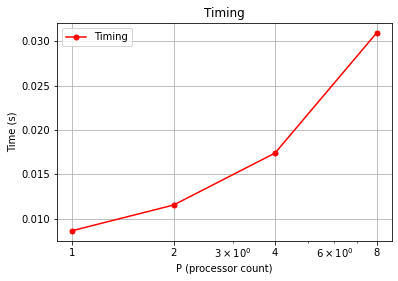

In [9]:
figure(1)
clf()

  
semilogx(PL,T,'r.-',ms=10,label='Timing')

# Make nice tick marks
pstr = ([int(p) for p in PL])
xticks(PL,pstr)

title(r'Timing')
xlabel('P (processor count)')
ylabel('Time (s)')

legend()

grid();

### Observations on timing results

What do you observe about your timing results found above?  Is there a benefit to using multiprocessing to compute the mean of a large array of numbers? Why or why not? 

(your answers here). 

From the timing result illustrated by the figure above, we observe that the amount of time required to compute the mean increases as the number of processes. Judging by this result alone, it isn't wise to compute the mean of a large array using multiprocessing.

<hr style="border-width:4px; border-color:coral"></hr>

## Problem 4  :  Weak scaling and efficiency (571)

<hr style="border-width:4px; border-color:coral"></hr>

We can verify the "weak scalability" of `mp_mean` routine by running the code using $P=1,2,4,8, 16$ process(es) for a data array of length $M=P \times M_0$ and store the timing results.    If our `mp_mean` routine scales perfectly, the total time should be the same for all five runs, since each process will sum the numbers in a data array of length $M_0$.  However, due to overhead (or "latency"), we don't see perfect scaling in practice. 

We can model the total time $T$ that `mp_mean` will take to run using `P` processes using the equation

\begin{equation}
T = T_s + \alpha P
\end{equation}

where $T_s$ is the time to compute the mean of $M_0$ numbers using a serial algorithm (`mean_serial`) and $\alpha$ is the overhead associated with launching a single process and sending data to the process. 

Model *efficiency* can then be computed as 

\begin{equation}
E = \frac{T_s}{T_s + \alpha P} \approx 1 - \frac{\alpha P}{T_s}, \qquad \frac{\alpha P}{T_s} \ll 1
\end{equation}

Under the assumption that $\alpha$ is small relative to $T_s$, we expect $E$ to be close to 1, and our algorithm will be close to 100% efficient. 

The *latency* $L$ in the system can be modeled as

\begin{equation}
L = T-T_s = \alpha P
\end{equation}

In this problem, you will explore the efficiency of the routine `mp_mean`. 

#### To Do


* Run the code below to get an array `T_weak` of timing results for the simulation run on $P=1,2,4,8,16$ processes.  

* Compute the time $T_s$ it takes to sum $M_0 = 2^N$ numbers using a serial algorithm (also in code below). To start, choose $M_0 = 2^{20}$. 

* Plot the *computed* efficiency $E = T_s/T_{weak}$ verses $P$ using timing results in the array `T_weak`.  
 
* Using linear regression, (e.g. Numpy `polyfit`) find paramters $m$ and $C$ for the latency model

\begin{equation}
\log(L) = \log(T-T_s) =  m\log(P) + C. 
\end{equation}

From this, you can obtain $\alpha$ as $\alpha = e^C$.   Your slope $m$ should be close to 1. 
Report the value of $\alpha$ and a slope $m$ that you get. See the Multiprocessing notebook  for details on how to compute these parameters.  

* Plot the *model* efficiency $E=T_s/(T_s + \alpha P)$ on the same graph as your computed efficiency. 

* Answer questions below. 

For both the computed and model efficiencies, you plot should actually plot efficiency as a percentage.  That is, plot $100 E$ in both cases.   Use a *semilogx* plot for both efficiency curves. 

#### Tips

* Start with $M_0 = 2^{20}$. If you can,  push this to $M_0 = 2^{22}$ or $M_0 = 2^{24}$.


In [10]:
# [0.10908858 0.18828485 0.33706451 0.63119592 1.17750993]
def weak_timing(M0,P):
    M = P*M0
    data = [random.random() for i in range(M)]
    results = %timeit -r 1 -n 1 -o  data_mean = mp_mean(data,p=P)   
    T = results.best
    return T

print(f"{'--'*17} M0=2^20 {'--'*17}")
M01 = 2**20
def getTweak(M0):
    P = array([1,2,4,8,16])  # Processor count
    T_weak = empty(P.shape)
    for i in range(len(P)):
        T_weak[i] = weak_timing(M0,P[i])    
    return T_weak
T_weak1=getTweak(M01)
print(T_weak1)    # weak timing in seconds.



print("")
print(f"{'--'*17} M0=2^24 {'--'*17}")
print("")

M02=2**(24)

T_weak2=getTweak(M02)
print(T_weak2)

---------------------------------- M0=2^20 ----------------------------------
108 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
164 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
303 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
652 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[0.10760641 0.1638871  0.30267245 0.65229448 1.12284184]

---------------------------------- M0=2^24 ----------------------------------

1.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.56 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
23.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[ 1.4301903   2.4292399   4.55810511 10.13522009 23.09502025]


Time the serial code to compute $T_s$. 

In [11]:
# Run serial routine to compute Ts
def serial(M0):
    data = [random.random() for i in range(M0)]
    results = %timeit -r 5 -n 5 -o mean_true = serial_mean(data)
    print("Best time (Ts) : {:.4f} (s)".format(results.best))
    print("")
    Ts = results.best
    return Ts
M0=2**20
print(f"{'--'*17} M0=2^20 {'--'*17}")
Ts1=serial(M0)
print(f"Ts = {Ts1:.2f} (s)")
print("")

M02=2**24
print(f"{'--'*17} M0=2^24 {'--'*17}")
Ts2=serial(M02)
print(f"Ts = {Ts2:.2f} (s)")


---------------------------------- M0=2^20 ----------------------------------
47 ms ± 1.05 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
Best time (Ts) : 0.0463 (s)

Ts = 0.05 (s)

---------------------------------- M0=2^24 ----------------------------------
786 ms ± 18 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
Best time (Ts) : 0.7656 (s)

Ts = 0.77 (s)


In [12]:
# Approximate alpha using linear regression
def alpha(Tweak,Ts,P=[1,2,4,8,16]):
    L = (Tweak - Ts)
    pC = polyfit(log(P),log(L),1)
    p = pC[0]  # power p
    Cbar = pC[1]  # Constant C
    alpha=exp(Cbar)
    print(f"Power p is approx. {p:.2f}")
    print(f"Constant C is approx. {Cbar:.2e} (s)")
    print(f"alpha = {alpha}")
    return alpha


print(f"{'--'*17} M0=2^(20) {'--'*17}")
alpha1=alpha(T_weak1,Ts1)
print(" ")

print(f"{'--'*17} M0=2^(24) {'--'*17}")
alpha2=alpha(T_weak2,Ts2)




---------------------------------- M0=2^(20) ----------------------------------
Power p is approx. 1.06
Constant C is approx. -2.82e+00 (s)
alpha = 0.05969950210418932
 
---------------------------------- M0=2^(24) ----------------------------------
Power p is approx. 1.26
Constant C is approx. -3.96e-01 (s)
alpha = 0.6729618730308499


#### Efficiency plots

<Figure size 432x288 with 0 Axes>

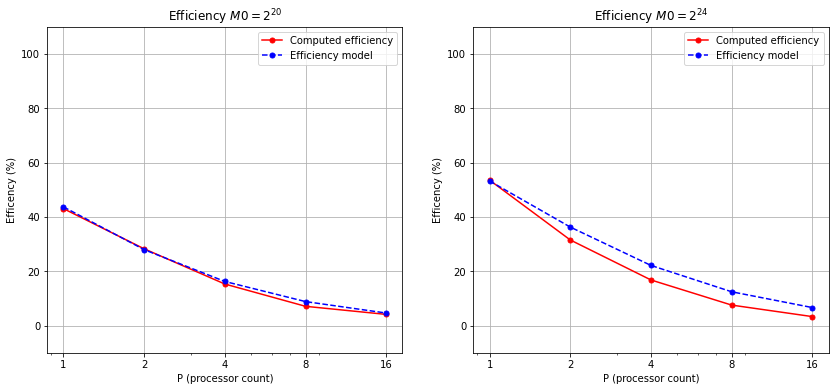

In [13]:

P=array([1,2,4,8,16])

#model efficiency
def Eff(P,Ts,alpha):
    return Ts/(Ts+alpha*P)

figure(2)
clf()
figure(figsize=(14, 6)) 


subplot(1,2,1)
E1 = (Ts1/T_weak1) 
semilogx(P,100*E1,'r.-',ms=10,label='Computed efficiency')
semilogx(P,100*Eff(P,Ts1,alpha1),'b.--',ms=10,label="Efficiency model")
pstr = ([f'{p}' for p in P])
xticks(P,pstr)
ylim([-10,110])
title(r'Efficiency $M0=2^{20}$')
xlabel('P (processor count)')
ylabel('Efficency (%)')
grid()
legend()



subplot(1,2,2)
E2 = (Ts2/T_weak2) 
semilogx(P,100*E2,'r.-',ms=10,label='Computed efficiency')
semilogx(P,100*Eff(P,Ts2,alpha2),'b.--',ms=10,label="Efficiency model")
pstr = ([f'{p}' for p in P])
xticks(P,pstr)
ylim([-10,110])
title(r'Efficiency $M0=2^{24}$')
xlabel('P (processor count)')
ylabel('Efficency (%)')
grid()
legend()




### Questions
<hr style="border-width:2px; border-color:black"></hr>

* Comment on the "efficiency" of the `mp_mean` routine when run on multiple processes.  Is the routine `mp_mean` *efficient* ? 

* As the size of the data array increases, we expect $T_s$ to increase.   Does this mean that `mp_mean` is more efficient for larger data arrays?  **Hint:** The latency parameter $\alpha$ depends on the size of the data array (Why?)  Can we always assume that $\alpha P/T_s$ is "small" (e.g. less than 1)?  

### Answer

(your answers here) 
...


* By observing the figures above, we see that the mp_mean routine performs badly, the efficiency drops as the number of processes increases. 

* The answer is no, mp mean is not always more efficient with bigger data arrays. Due to the fact that sending data between processors takes longer as the size of the data array increases, the latency parameter 𝛼 is dependent on the size of the data array. As a result, the ratio 𝛼𝑃/𝑇𝑠 and the latency parameter both grow as the size of the data array increases. As the size of the data array grows, it is possible for 𝛼𝑃/𝑇𝑠 to become higher than 1, therefore we cannot always assume that it is "small" (i.e., less than 1).
